# The MRSAA-c Component

### Setup

Our MRSAA-c implementation is done on Landlab's Network Model Grid (NMG), you can think of it as a graph. So let's see a quick example of this

<AxesSubplot:xlabel='x', ylabel='y'>

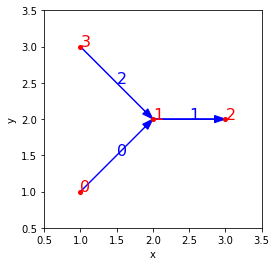

In [1]:
from landlab import NetworkModelGrid
import landlab.plot.graph as graph

x_of_nodes = [1, 1, 2, 3]
y_of_nodes = [3, 1, 2, 2]
links = [(0,2) ,(1,2), (2,3)]

ngrid = NetworkModelGrid((y_of_nodes, x_of_nodes), links)
graph.plot_graph(ngrid, at="node,link", with_id=True)



This allows us to represent river networks and run processes exclusive to them on this grid. In practice we use topographic data which is usually read as a Raster file (equally spaced 2D grid of topographic elevation). For now we will use the following single channel generated raster

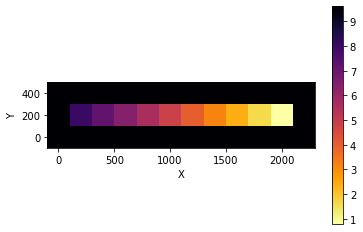

In [4]:
from landlab import RasterModelGrid, imshow_grid

# grid parameters
total_length = 2000
reach_lenght = 200
slope = 0.004
steepness = slope * reach_lenght
# grid geometry creation
n = round(total_length / reach_lenght)
shape = (3, n + 2)
cliff_height = steepness * n * 1.2 + 0.01
topography = [cliff_height] * (3 * (n+2))
# create the grid
for i in range(n):
    topography[n + i + 3] = steepness * (n - i)
# store it as a raster file
rastergrid = RasterModelGrid(shape=shape, xy_spacing=reach_lenght)
rastergrid.add_field("topographic__elevation", topography)
imshow_grid(rastergrid, rastergrid.at_node["topographic__elevation"], cmap='inferno_r')


we can then use landlab's function ```network_grid_from_raster``` to create a NMG

<AxesSubplot:xlabel='x', ylabel='y'>

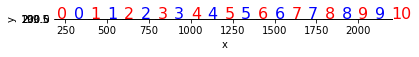

In [6]:
from landlab.grid.create_network import network_grid_from_raster

ngrid = network_grid_from_raster(rastergrid)
graph.plot_graph(ngrid, at="node,link", with_id=True)

Now we need to set up the parameters of the network and sediment. For now we will use default values. Additionally we need the direction of the flow as a ```FlowDirector``` object

In [7]:
from landlab.components import Componentcita as comp
from landlab.components import FlowDirectorSteepest

comp.Componentcita._preset_fields(ngrid=ngrid)
flow_director = FlowDirectorSteepest(ngrid)
flow_director.run_one_step()

And finally create an instance of our component

In [8]:
nety = comp.Componentcita(ngrid, flow_director)

The shape of this specific network is a line so we can plot it field values in a fairly simple way

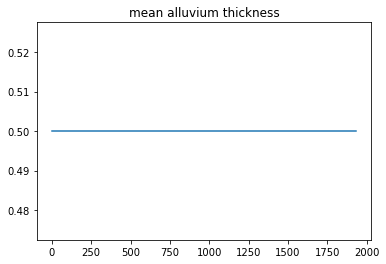

In [9]:
import matplotlib.pyplot as plt
import numpy as np
YEAR = 365.25 * 24 * 60 * 60

xs = np.cumsum(ngrid.at_node["reach_length"])
xs = xs - xs[0]

ys = ngrid.at_node["mean_alluvium_thickness"]
plt.plot(xs, ys, label="initial")
plt.title("mean alluvium thickness")
ax = plt.gca()
fig = plt.gcf()


Now let's see how the alluvium changes as we let the model run for a year with a constant sediment flux at the upstream end

In [10]:
# Run the model for a year
dt = YEAR/1000
for _ in range(1000):
    nety.run_one_step(dt=dt, q_in=0.000834)

# plot the new alluvium
ys = ngrid.at_node["mean_alluvium_thickness"]
ax.plot(xs, ys, label="a year after")
plt.show(fig)

C:\Users\Paquito\Desktop\Github\landlab\landlab\components\Sergio\Componentcita.py:703: RuntimeWarning: divide by zero encountered in divide
  self._grid.at_node["sed_capacity"][self.sources] = flux_in / p
C:\Users\Paquito\Desktop\Github\landlab\landlab\components\Sergio\Componentcita.py:597: RuntimeWarning: invalid value encountered in multiply
  erosion = (self._grid.at_node["flood_intermittency"]
C:\Users\Paquito\Desktop\Github\landlab\landlab\components\Sergio\Componentcita.py:618: RuntimeWarning: invalid value encountered in multiply
  pq = p * q


In [11]:
%matplotlib inline
fig = plt.gcf()
plt.show(fig)

<Figure size 432x288 with 0 Axes>

In [ ]:
print(ngrid["node"].keys())

In [ ]:
ys